In [1]:
import torch
import torch.nn as nn
import pandas as pd
from tqdm import tqdm
from functools import partial
import joblib

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from src.data.tokenizers.basic_tokenizer import BasicWordTokenizer, BasicCharTokenizer, CustomWordCharTokenizer
from src.data.datastruct import Sample, Batch
from src.data.collate import collate_func, create_batch, create_samples
from src.models.neural_text_classifier import TicketTextClassifierV01
from src.training.train_neural import train_model
from src.evaluation.neural_eval import evaluate, inference_one
from src.evaluation.metrics import evaluate as cm_evaluate, format_cm

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
DATA_PATH = "../data/raw/all_tickets_processed_improved_v3.csv"
df = pd.read_csv(DATA_PATH)
df.head()

,Document,Topic_group
0,connection with icon icon dear please setup ic...,Hardware
1,work experience user work experience user hi w...,Access
2,requesting for meeting requesting meeting hi p...,Hardware
3,reset passwords for external accounts re expir...,Access
4,mail verification warning hi has got attached ...,Miscellaneous


In [4]:
X = df["Document"]
y = df["Topic_group"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=2)

In [5]:
labelencoder: LabelEncoder = joblib.load("../artifacts/labelencoder_neural_v01.pkl")

In [6]:
y_train_encoded = labelencoder.transform(y_train)
y_test_encoded = labelencoder.transform(y_test)

In [7]:
tokenizer_bi = BasicWordTokenizer()
tokenizer_bi.fit(X_train, 2)

tokenizer_unibi = BasicWordTokenizer()
tokenizer_unibi.fit(X_train, (1, 2))

Tokenizer fitted. Vocab size:  30002
Tokenizer fitted. Vocab size:  30002


In [8]:
train_samples_bi = create_samples(X_train, y_train_encoded, tokenizer_bi)
test_samples_bi = create_samples(X_test, y_test_encoded, tokenizer_bi)

train_samples_unibi = create_samples(X_train, y_train_encoded, tokenizer_unibi)
test_samples_unibi = create_samples(X_test, y_test_encoded, tokenizer_unibi)

In [9]:
EPOCHS = 50
EMBEDDING_DIM = 256
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 64
N_CLASSES = len(list(set(y)))

model_bi = TicketTextClassifierV01(
    vocab_size=len(tokenizer_bi),
    embedding_dim=EMBEDDING_DIM,
    pad_id=tokenizer_bi.get_pad_id(),
    n_classes=N_CLASSES
).to(device)

model_unibi = TicketTextClassifierV01(
    vocab_size=len(tokenizer_unibi),
    embedding_dim=EMBEDDING_DIM,
    pad_id=tokenizer_unibi.get_pad_id(),
    n_classes=N_CLASSES
).to(device)


criterion = nn.CrossEntropyLoss()

test_batches_bi = create_batch(TEST_BATCH_SIZE, test_samples_bi, pad_id=tokenizer_bi.get_pad_id(), 
                               device=device, shuffle=True, 
                               random_state=43)

test_batches_unibi = create_batch(TEST_BATCH_SIZE, test_samples_unibi, pad_id=tokenizer_unibi.get_pad_id(), 
                               device=device, shuffle=True, 
                               random_state=43)

In [14]:
history_bi = train_model(
    model_bi, total_epochs=EPOCHS, train_samples=train_samples_bi, test_batches=test_batches_bi, training_batch_size=TRAIN_BATCH_SIZE,
    pad_id=tokenizer_bi.get_pad_id(), criterion=criterion, early_stop=True, lr=0.0001, random_state=43,device=device
)

  2%|▏         | 1/50 [00:11<09:11, 11.26s/it]


        Epoch 1
        Train Loss: 1.7243 | Train F1: 0.2281
        Val   Loss: 1.5771 | Val   F1: 0.2958
        


  4%|▍         | 2/50 [00:21<08:29, 10.62s/it]


        Epoch 2
        Train Loss: 1.4655 | Train F1: 0.3840
        Val   Loss: 1.3806 | Val   F1: 0.4252
        


  6%|▌         | 3/50 [00:32<08:18, 10.60s/it]


        Epoch 3
        Train Loss: 1.2941 | Train F1: 0.4751
        Val   Loss: 1.2496 | Val   F1: 0.4831
        


  8%|▊         | 4/50 [00:41<07:53, 10.28s/it]


        Epoch 4
        Train Loss: 1.1700 | Train F1: 0.5264
        Val   Loss: 1.1586 | Val   F1: 0.5241
        


 10%|█         | 5/50 [00:52<07:48, 10.42s/it]


        Epoch 5
        Train Loss: 1.0745 | Train F1: 0.5627
        Val   Loss: 1.0890 | Val   F1: 0.5516
        


 12%|█▏        | 6/50 [01:02<07:36, 10.37s/it]


        Epoch 6
        Train Loss: 0.9938 | Train F1: 0.5915
        Val   Loss: 1.0357 | Val   F1: 0.5713
        


 14%|█▍        | 7/50 [01:12<07:16, 10.15s/it]


        Epoch 7
        Train Loss: 0.9279 | Train F1: 0.6160
        Val   Loss: 0.9910 | Val   F1: 0.6001
        


 16%|█▌        | 8/50 [01:22<07:07, 10.18s/it]


        Epoch 8
        Train Loss: 0.8700 | Train F1: 0.6485
        Val   Loss: 0.9550 | Val   F1: 0.6241
        


 18%|█▊        | 9/50 [01:32<06:53, 10.08s/it]


        Epoch 9
        Train Loss: 0.8162 | Train F1: 0.6768
        Val   Loss: 0.9244 | Val   F1: 0.6434
        


 20%|██        | 10/50 [01:42<06:36,  9.91s/it]


        Epoch 10
        Train Loss: 0.7708 | Train F1: 0.7022
        Val   Loss: 0.9011 | Val   F1: 0.6562
        


 22%|██▏       | 11/50 [01:52<06:30, 10.02s/it]


        Epoch 11
        Train Loss: 0.7293 | Train F1: 0.7186
        Val   Loss: 0.8785 | Val   F1: 0.6704
        


 24%|██▍       | 12/50 [02:02<06:26, 10.18s/it]


        Epoch 12
        Train Loss: 0.6900 | Train F1: 0.7373
        Val   Loss: 0.8566 | Val   F1: 0.6821
        


 26%|██▌       | 13/50 [02:13<06:17, 10.21s/it]


        Epoch 13
        Train Loss: 0.6539 | Train F1: 0.7510
        Val   Loss: 0.8421 | Val   F1: 0.6907
        


 28%|██▊       | 14/50 [02:23<06:09, 10.26s/it]


        Epoch 14
        Train Loss: 0.6198 | Train F1: 0.7676
        Val   Loss: 0.8315 | Val   F1: 0.6969
        


 30%|███       | 15/50 [02:33<05:54, 10.14s/it]


        Epoch 15
        Train Loss: 0.5883 | Train F1: 0.7805
        Val   Loss: 0.8211 | Val   F1: 0.7057
        


 32%|███▏      | 16/50 [02:43<05:39,  9.98s/it]


        Epoch 16
        Train Loss: 0.5619 | Train F1: 0.7888
        Val   Loss: 0.8106 | Val   F1: 0.7099
        


 34%|███▍      | 17/50 [02:53<05:31, 10.04s/it]


        Epoch 17
        Train Loss: 0.5319 | Train F1: 0.8011
        Val   Loss: 0.8087 | Val   F1: 0.7153
        


 36%|███▌      | 18/50 [03:03<05:23, 10.11s/it]


        Epoch 18
        Train Loss: 0.5060 | Train F1: 0.8094
        Val   Loss: 0.8034 | Val   F1: 0.7188
        


 38%|███▊      | 19/50 [03:13<05:14, 10.15s/it]


        Epoch 19
        Train Loss: 0.4803 | Train F1: 0.8193
        Val   Loss: 0.7981 | Val   F1: 0.7229
        


 40%|████      | 20/50 [03:24<05:07, 10.26s/it]


        Epoch 20
        Train Loss: 0.4576 | Train F1: 0.8285
        Val   Loss: 0.7975 | Val   F1: 0.7286
        


 42%|████▏     | 21/50 [03:34<04:54, 10.17s/it]


        Epoch 21
        Train Loss: 0.4350 | Train F1: 0.8357
        Val   Loss: 0.7948 | Val   F1: 0.7314
        


 44%|████▍     | 22/50 [03:43<04:38,  9.95s/it]


        Epoch 22
        Train Loss: 0.4161 | Train F1: 0.8461
        Val   Loss: 0.7994 | Val   F1: 0.7322
        


 46%|████▌     | 23/50 [03:53<04:29,  9.99s/it]


        Epoch 23
        Train Loss: 0.3949 | Train F1: 0.8542
        Val   Loss: 0.7960 | Val   F1: 0.7365
        


 48%|████▊     | 24/50 [04:04<04:22, 10.10s/it]


        Epoch 24
        Train Loss: 0.3742 | Train F1: 0.8616
        Val   Loss: 0.8015 | Val   F1: 0.7375
        


 50%|█████     | 25/50 [04:14<04:11, 10.07s/it]


        Epoch 25
        Train Loss: 0.3566 | Train F1: 0.8676
        Val   Loss: 0.8055 | Val   F1: 0.7391
        


 52%|█████▏    | 26/50 [04:24<04:06, 10.27s/it]


        Epoch 26
        Train Loss: 0.3380 | Train F1: 0.8747
        Val   Loss: 0.8096 | Val   F1: 0.7419
        


 54%|█████▍    | 27/50 [04:35<03:57, 10.32s/it]


        Epoch 27
        Train Loss: 0.3197 | Train F1: 0.8817
        Val   Loss: 0.8187 | Val   F1: 0.7439
        


 56%|█████▌    | 28/50 [04:45<03:44, 10.18s/it]


        Epoch 28
        Train Loss: 0.3036 | Train F1: 0.8880
        Val   Loss: 0.8246 | Val   F1: 0.7439
        


 58%|█████▊    | 29/50 [04:55<03:35, 10.27s/it]


        Epoch 29
        Train Loss: 0.2872 | Train F1: 0.8968
        Val   Loss: 0.8327 | Val   F1: 0.7447
        


 60%|██████    | 30/50 [05:05<03:23, 10.16s/it]


        Epoch 30
        Train Loss: 0.2731 | Train F1: 0.9007
        Val   Loss: 0.8373 | Val   F1: 0.7467
        


 62%|██████▏   | 31/50 [05:15<03:10, 10.03s/it]


        Epoch 31
        Train Loss: 0.2593 | Train F1: 0.9068
        Val   Loss: 0.8579 | Val   F1: 0.7462
        


 64%|██████▍   | 32/50 [05:25<03:03, 10.17s/it]


        Epoch 32
        Train Loss: 0.2449 | Train F1: 0.9123
        Val   Loss: 0.8623 | Val   F1: 0.7469
        


 66%|██████▌   | 33/50 [05:36<02:54, 10.25s/it]


        Epoch 33
        Train Loss: 0.2310 | Train F1: 0.9174
        Val   Loss: 0.8756 | Val   F1: 0.7468
        


 68%|██████▊   | 34/50 [05:46<02:42, 10.14s/it]


        Epoch 34
        Train Loss: 0.2203 | Train F1: 0.9217
        Val   Loss: 0.8875 | Val   F1: 0.7482
        


 70%|███████   | 35/50 [05:56<02:32, 10.15s/it]


        Epoch 35
        Train Loss: 0.2058 | Train F1: 0.9273
        Val   Loss: 0.9111 | Val   F1: 0.7480
        


 72%|███████▏  | 36/50 [06:06<02:21, 10.08s/it]


        Epoch 36
        Train Loss: 0.1946 | Train F1: 0.9317
        Val   Loss: 0.9145 | Val   F1: 0.7492
        


 74%|███████▍  | 37/50 [06:15<02:09,  9.93s/it]


        Epoch 37
        Train Loss: 0.1845 | Train F1: 0.9359
        Val   Loss: 0.9200 | Val   F1: 0.7496
        


 76%|███████▌  | 38/50 [06:26<02:00, 10.07s/it]


        Epoch 38
        Train Loss: 0.1717 | Train F1: 0.9400
        Val   Loss: 0.9454 | Val   F1: 0.7500
        


 78%|███████▊  | 39/50 [06:36<01:51, 10.13s/it]


        Epoch 39
        Train Loss: 0.1624 | Train F1: 0.9443
        Val   Loss: 0.9507 | Val   F1: 0.7514
        


 80%|████████  | 40/50 [06:46<01:41, 10.16s/it]


        Epoch 40
        Train Loss: 0.1524 | Train F1: 0.9482
        Val   Loss: 0.9771 | Val   F1: 0.7506
        


 82%|████████▏ | 41/50 [06:57<01:32, 10.26s/it]


        Epoch 41
        Train Loss: 0.1445 | Train F1: 0.9502
        Val   Loss: 0.9918 | Val   F1: 0.7495
        


 84%|████████▍ | 42/50 [07:07<01:21, 10.19s/it]


        Epoch 42
        Train Loss: 0.1370 | Train F1: 0.9540
        Val   Loss: 1.0028 | Val   F1: 0.7524
        


 86%|████████▌ | 43/50 [07:16<01:10, 10.00s/it]


        Epoch 43
        Train Loss: 0.1271 | Train F1: 0.9581
        Val   Loss: 1.0222 | Val   F1: 0.7512
        


 88%|████████▊ | 44/50 [07:26<01:00, 10.05s/it]


        Epoch 44
        Train Loss: 0.1197 | Train F1: 0.9610
        Val   Loss: 1.0431 | Val   F1: 0.7506
        


 88%|████████▊ | 44/50 [07:37<01:02, 10.39s/it]


        Epoch 45
        Train Loss: 0.1134 | Train F1: 0.9630
        Val   Loss: 1.0550 | Val   F1: 0.7502
        
Early stopping at epoch: 44


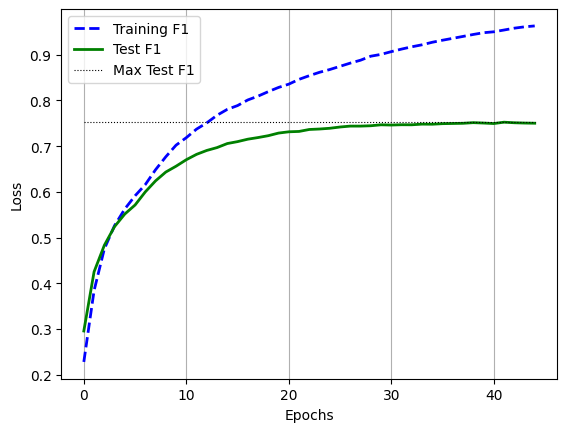

In [ ]:
# plot f1
import matplotlib.pyplot as plt

plt.plot(
    range(len(history_bi)), [e[2] for e in history_bi], label='Training F1', linewidth=2.0, color='blue', ls='dashed'
)
plt.plot(
    range(len(history_bi)), [e[3] for e in history_bi], label='Test F1', linewidth=2.0, color='green', ls='solid'
)
plt.plot(
    range(len(history_bi)), [max([e[3] for e in history_bi])]*len(history_bi), label='Max Test F1', linewidth=0.8, color='black', ls='dotted'
)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(axis='x')

In [15]:
bi_test_loss, bi_test_pred, bi_test_true = evaluate(
    model_bi, test_batches_bi, criterion
)
bi_cm = cm_evaluate(bi_test_true, bi_test_pred)
format_cm(bi_cm, class_names=list(labelencoder.classes_), normalize=True)

              precision    recall  f1-score   support

           0     0.7581    0.7916    0.7745      1425
           1     0.5974    0.5312    0.5624       352
           2     0.8137    0.7723    0.7925      2183
           3     0.7218    0.8087    0.7628      2724
           4     0.7888    0.6958    0.7393       424
           5     0.7460    0.6948    0.7195      1412
           6     0.9212    0.8296    0.8730       493
           7     0.8118    0.7459    0.7775       555

    accuracy                         0.7633      9568
   macro avg     0.7698    0.7337    0.7502      9568
weighted avg     0.7656    0.7633    0.7630      9568



,Pred: Access,Pred: Administrative rights,Pred: HR Support,Pred: Hardware,Pred: Internal Project,Pred: Miscellaneous,Pred: Purchase,Pred: Storage
True: Access,0.791579,0.014737,0.044912,0.099649,0.006316,0.031579,0.002105,0.009123
True: Administrative rights,0.059659,0.531250,0.042614,0.303977,0.008523,0.034091,0.014205,0.005682
True: HR Support,0.039395,0.006413,0.772332,0.112689,0.009162,0.046267,0.001832,0.011910
True: Hardware,0.049559,0.023495,0.053231,0.808737,0.004772,0.042952,0.005507,0.011747
True: Internal Project,0.049528,0.009434,0.082547,0.075472,0.695755,0.077830,0.004717,0.004717
True: Miscellaneous,0.050992,0.009207,0.066572,0.142351,0.021246,0.694759,0.003541,0.011331
True: Purchase,0.010142,0.006085,0.014199,0.103448,0.006085,0.020284,0.829615,0.010142
True: Storage,0.036036,0.012613,0.046847,0.126126,0.001802,0.028829,0.001802,0.745946


In [16]:
history_unibi = train_model(
    model_unibi, total_epochs=EPOCHS, train_samples=train_samples_unibi, test_batches=test_batches_unibi, training_batch_size=TRAIN_BATCH_SIZE,
    pad_id=tokenizer_unibi.get_pad_id(), criterion=criterion, early_stop=True, lr=0.0001, random_state=43,device=device
)

  2%|▏         | 1/50 [00:10<08:34, 10.49s/it]


        Epoch 1
        Train Loss: 1.5876 | Train F1: 0.3075
        Val   Loss: 1.2775 | Val   F1: 0.4588
        


  4%|▍         | 2/50 [00:21<08:42, 10.89s/it]


        Epoch 2
        Train Loss: 1.0856 | Train F1: 0.5535
        Val   Loss: 0.9515 | Val   F1: 0.6040
        


  6%|▌         | 3/50 [00:32<08:25, 10.76s/it]


        Epoch 3
        Train Loss: 0.8497 | Train F1: 0.6544
        Val   Loss: 0.7983 | Val   F1: 0.6809
        


  8%|▊         | 4/50 [00:42<08:12, 10.71s/it]


        Epoch 4
        Train Loss: 0.7175 | Train F1: 0.7194
        Val   Loss: 0.7093 | Val   F1: 0.7285
        


 10%|█         | 5/50 [00:53<07:57, 10.61s/it]


        Epoch 5
        Train Loss: 0.6311 | Train F1: 0.7635
        Val   Loss: 0.6542 | Val   F1: 0.7586
        


 12%|█▏        | 6/50 [01:03<07:47, 10.62s/it]


        Epoch 6
        Train Loss: 0.5671 | Train F1: 0.7918
        Val   Loss: 0.6154 | Val   F1: 0.7718
        


 14%|█▍        | 7/50 [01:15<07:44, 10.81s/it]


        Epoch 7
        Train Loss: 0.5192 | Train F1: 0.8088
        Val   Loss: 0.5862 | Val   F1: 0.7879
        


 16%|█▌        | 8/50 [01:25<07:29, 10.70s/it]


        Epoch 8
        Train Loss: 0.4812 | Train F1: 0.8245
        Val   Loss: 0.5657 | Val   F1: 0.7970
        


 18%|█▊        | 9/50 [01:36<07:22, 10.79s/it]


        Epoch 9
        Train Loss: 0.4488 | Train F1: 0.8370
        Val   Loss: 0.5501 | Val   F1: 0.8051
        


 20%|██        | 10/50 [01:47<07:07, 10.70s/it]


        Epoch 10
        Train Loss: 0.4207 | Train F1: 0.8486
        Val   Loss: 0.5386 | Val   F1: 0.8100
        


 22%|██▏       | 11/50 [01:58<06:59, 10.76s/it]


        Epoch 11
        Train Loss: 0.3940 | Train F1: 0.8594
        Val   Loss: 0.5271 | Val   F1: 0.8154
        


 24%|██▍       | 12/50 [02:08<06:42, 10.60s/it]


        Epoch 12
        Train Loss: 0.3724 | Train F1: 0.8674
        Val   Loss: 0.5182 | Val   F1: 0.8195
        


 26%|██▌       | 13/50 [02:19<06:35, 10.69s/it]


        Epoch 13
        Train Loss: 0.3516 | Train F1: 0.8743
        Val   Loss: 0.5114 | Val   F1: 0.8233
        


 28%|██▊       | 14/50 [02:29<06:24, 10.69s/it]


        Epoch 14
        Train Loss: 0.3307 | Train F1: 0.8825
        Val   Loss: 0.5054 | Val   F1: 0.8269
        


 30%|███       | 15/50 [02:41<06:22, 10.92s/it]


        Epoch 15
        Train Loss: 0.3130 | Train F1: 0.8904
        Val   Loss: 0.5031 | Val   F1: 0.8296
        


 32%|███▏      | 16/50 [02:51<06:06, 10.79s/it]


        Epoch 16
        Train Loss: 0.2945 | Train F1: 0.8962
        Val   Loss: 0.4999 | Val   F1: 0.8305
        


 34%|███▍      | 17/50 [03:02<05:53, 10.70s/it]


        Epoch 17
        Train Loss: 0.2802 | Train F1: 0.9019
        Val   Loss: 0.4993 | Val   F1: 0.8319
        


 36%|███▌      | 18/50 [03:12<05:41, 10.68s/it]


        Epoch 18
        Train Loss: 0.2634 | Train F1: 0.9081
        Val   Loss: 0.4988 | Val   F1: 0.8330
        


 38%|███▊      | 19/50 [03:23<05:34, 10.78s/it]


        Epoch 19
        Train Loss: 0.2499 | Train F1: 0.9133
        Val   Loss: 0.4999 | Val   F1: 0.8353
        


 40%|████      | 20/50 [03:34<05:23, 10.77s/it]


        Epoch 20
        Train Loss: 0.2354 | Train F1: 0.9194
        Val   Loss: 0.4991 | Val   F1: 0.8349
        


 42%|████▏     | 21/50 [03:45<05:11, 10.73s/it]


        Epoch 21
        Train Loss: 0.2231 | Train F1: 0.9237
        Val   Loss: 0.4996 | Val   F1: 0.8371
        


 44%|████▍     | 22/50 [03:56<05:03, 10.83s/it]


        Epoch 22
        Train Loss: 0.2096 | Train F1: 0.9294
        Val   Loss: 0.5036 | Val   F1: 0.8374
        


 46%|████▌     | 23/50 [04:07<04:52, 10.85s/it]


        Epoch 23
        Train Loss: 0.1977 | Train F1: 0.9336
        Val   Loss: 0.5074 | Val   F1: 0.8387
        


 48%|████▊     | 24/50 [04:17<04:39, 10.75s/it]


        Epoch 24
        Train Loss: 0.1858 | Train F1: 0.9374
        Val   Loss: 0.5130 | Val   F1: 0.8394
        


 50%|█████     | 25/50 [04:28<04:31, 10.87s/it]


        Epoch 25
        Train Loss: 0.1741 | Train F1: 0.9412
        Val   Loss: 0.5164 | Val   F1: 0.8391
        


 52%|█████▏    | 26/50 [04:40<04:27, 11.13s/it]


        Epoch 26
        Train Loss: 0.1630 | Train F1: 0.9454
        Val   Loss: 0.5242 | Val   F1: 0.8388
        


 54%|█████▍    | 27/50 [04:52<04:18, 11.22s/it]


        Epoch 27
        Train Loss: 0.1535 | Train F1: 0.9498
        Val   Loss: 0.5303 | Val   F1: 0.8405
        


 56%|█████▌    | 28/50 [05:02<04:02, 11.04s/it]


        Epoch 28
        Train Loss: 0.1434 | Train F1: 0.9542
        Val   Loss: 0.5369 | Val   F1: 0.8393
        


 58%|█████▊    | 29/50 [05:13<03:53, 11.11s/it]


        Epoch 29
        Train Loss: 0.1340 | Train F1: 0.9569
        Val   Loss: 0.5442 | Val   F1: 0.8391
        


 58%|█████▊    | 29/50 [05:24<03:55, 11.20s/it]


        Epoch 30
        Train Loss: 0.1255 | Train F1: 0.9600
        Val   Loss: 0.5520 | Val   F1: 0.8387
        
Early stopping at epoch: 29


In [18]:
unibi_test_loss, unibi_test_pred, unibi_test_true = evaluate(
    model_unibi, test_batches_unibi, criterion
)
unibi_cm = cm_evaluate(unibi_test_true, unibi_test_pred)
format_cm(unibi_cm, class_names=list(labelencoder.classes_), normalize=True)

              precision    recall  f1-score   support

           0     0.8504    0.8856    0.8677      1425
           1     0.7028    0.7188    0.7107       352
           2     0.8827    0.8305    0.8558      2183
           3     0.8244    0.8517    0.8378      2724
           4     0.8463    0.8184    0.8321       424
           5     0.8043    0.8237    0.8139      1412
           6     0.9493    0.8742    0.9102       493
           7     0.8883    0.8739    0.8810       555

    accuracy                         0.8439      9568
   macro avg     0.8436    0.8346    0.8387      9568
weighted avg     0.8453    0.8439    0.8441      9568



,Pred: Access,Pred: Administrative rights,Pred: HR Support,Pred: Hardware,Pred: Internal Project,Pred: Miscellaneous,Pred: Purchase,Pred: Storage
True: Access,0.885614,0.005614,0.027368,0.048421,0.004211,0.025263,0.001404,0.002105
True: Administrative rights,0.022727,0.718750,0.011364,0.196023,0.014205,0.017045,0.014205,0.005682
True: HR Support,0.027485,0.003665,0.830508,0.073294,0.008246,0.046725,0.001374,0.008704
True: Hardware,0.033407,0.023862,0.037445,0.851689,0.004405,0.036344,0.004772,0.008076
True: Internal Project,0.021226,0.011792,0.049528,0.042453,0.818396,0.047170,0.000000,0.009434
True: Miscellaneous,0.029037,0.007082,0.041076,0.077904,0.014164,0.823654,0.000000,0.007082
True: Purchase,0.004057,0.010142,0.006085,0.075051,0.004057,0.024341,0.874239,0.002028
True: Storage,0.019820,0.010811,0.025225,0.055856,0.000000,0.014414,0.000000,0.873874


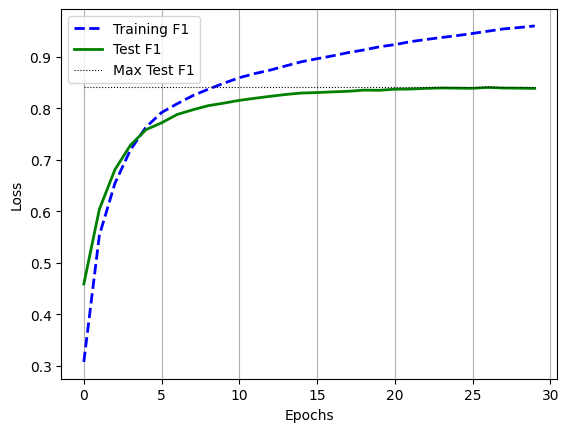

In [ ]:
# plot f1
import matplotlib.pyplot as plt

plt.plot(
    range(len(history_unibi)), [e[2] for e in history_unibi], label='Training F1', linewidth=2.0, color='blue', ls='dashed'
)
plt.plot(
    range(len(history_unibi)), [e[3] for e in history_unibi], label='Test F1', linewidth=2.0, color='green', ls='solid'
)
plt.plot(
    range(len(history_unibi)), [max([e[3] for e in history_unibi])]*len(history_unibi), label='Max Test F1', linewidth=0.8, color='black', ls='dotted'
)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(axis='x')

In [10]:
# char n gram(3, 5)

tokenizer_char3_5 = BasicCharTokenizer()
tokenizer_char3_5.fit(X_train, (3,5))

Tokenizer fitted. Vocab size:  28899


In [15]:
train_samples_char3_5 = create_samples(X_train, y_train_encoded, tokenizer_char3_5)
test_samples_char3_5 = create_samples(X_test, y_test_encoded, tokenizer_char3_5)

model_char3_5 = TicketTextClassifierV01(
    vocab_size=len(tokenizer_char3_5),
    embedding_dim=EMBEDDING_DIM,
    pad_id=tokenizer_char3_5.get_pad_id(),
    n_classes=N_CLASSES
).to(device)


criterion = nn.CrossEntropyLoss()

test_batches_char3_5 = create_batch(TEST_BATCH_SIZE, test_samples_char3_5, pad_id=tokenizer_char3_5.get_pad_id(), 
                               device=device, shuffle=True, 
                               random_state=43)


In [16]:
history_char3_5 = train_model(
    model_char3_5, total_epochs=EPOCHS, train_samples=train_samples_char3_5, test_batches=test_batches_char3_5, training_batch_size=TRAIN_BATCH_SIZE,
    pad_id=tokenizer_char3_5.get_pad_id(), criterion=criterion, early_stop=True, lr=0.0001, random_state=43,device=device
)

  2%|▏         | 1/50 [00:22<18:39, 22.84s/it]


        Epoch 1
        Train Loss: 1.5132 | Train F1: 0.3501
        Val   Loss: 1.0560 | Val   F1: 0.5742
        


  4%|▍         | 2/50 [00:41<16:16, 20.34s/it]


        Epoch 2
        Train Loss: 0.8633 | Train F1: 0.6511
        Val   Loss: 0.7508 | Val   F1: 0.7005
        


  6%|▌         | 3/50 [00:57<14:27, 18.47s/it]


        Epoch 3
        Train Loss: 0.6824 | Train F1: 0.7382
        Val   Loss: 0.6490 | Val   F1: 0.7573
        


  8%|▊         | 4/50 [01:14<13:35, 17.74s/it]


        Epoch 4
        Train Loss: 0.6028 | Train F1: 0.7860
        Val   Loss: 0.5975 | Val   F1: 0.7829
        


 10%|█         | 5/50 [01:30<12:49, 17.11s/it]


        Epoch 5
        Train Loss: 0.5524 | Train F1: 0.8067
        Val   Loss: 0.5665 | Val   F1: 0.7970
        


 12%|█▏        | 6/50 [01:46<12:24, 16.92s/it]


        Epoch 6
        Train Loss: 0.5179 | Train F1: 0.8226
        Val   Loss: 0.5452 | Val   F1: 0.8064
        


 14%|█▍        | 7/50 [02:03<11:58, 16.71s/it]


        Epoch 7
        Train Loss: 0.4931 | Train F1: 0.8315
        Val   Loss: 0.5297 | Val   F1: 0.8125
        


 16%|█▌        | 8/50 [02:19<11:42, 16.73s/it]


        Epoch 8
        Train Loss: 0.4705 | Train F1: 0.8406
        Val   Loss: 0.5180 | Val   F1: 0.8193
        


 18%|█▊        | 9/50 [02:36<11:19, 16.57s/it]


        Epoch 9
        Train Loss: 0.4520 | Train F1: 0.8462
        Val   Loss: 0.5082 | Val   F1: 0.8216
        


 20%|██        | 10/50 [02:53<11:09, 16.75s/it]


        Epoch 10
        Train Loss: 0.4358 | Train F1: 0.8533
        Val   Loss: 0.5014 | Val   F1: 0.8252
        


 22%|██▏       | 11/50 [03:09<10:42, 16.48s/it]


        Epoch 11
        Train Loss: 0.4206 | Train F1: 0.8575
        Val   Loss: 0.4946 | Val   F1: 0.8281
        


 24%|██▍       | 12/50 [03:26<10:32, 16.65s/it]


        Epoch 12
        Train Loss: 0.4087 | Train F1: 0.8617
        Val   Loss: 0.4894 | Val   F1: 0.8313
        


 26%|██▌       | 13/50 [03:42<10:09, 16.49s/it]


        Epoch 13
        Train Loss: 0.3978 | Train F1: 0.8662
        Val   Loss: 0.4845 | Val   F1: 0.8325
        


 28%|██▊       | 14/50 [03:59<10:01, 16.70s/it]


        Epoch 14
        Train Loss: 0.3863 | Train F1: 0.8711
        Val   Loss: 0.4816 | Val   F1: 0.8347
        


 30%|███       | 15/50 [04:15<09:41, 16.61s/it]


        Epoch 15
        Train Loss: 0.3768 | Train F1: 0.8733
        Val   Loss: 0.4771 | Val   F1: 0.8364
        


 32%|███▏      | 16/50 [04:33<09:35, 16.93s/it]


        Epoch 16
        Train Loss: 0.3658 | Train F1: 0.8773
        Val   Loss: 0.4741 | Val   F1: 0.8369
        


 34%|███▍      | 17/50 [04:49<09:13, 16.76s/it]


        Epoch 17
        Train Loss: 0.3576 | Train F1: 0.8815
        Val   Loss: 0.4717 | Val   F1: 0.8382
        


 36%|███▌      | 18/50 [05:07<09:07, 17.12s/it]


        Epoch 18
        Train Loss: 0.3483 | Train F1: 0.8831
        Val   Loss: 0.4696 | Val   F1: 0.8385
        


 38%|███▊      | 19/50 [05:24<08:46, 16.98s/it]


        Epoch 19
        Train Loss: 0.3412 | Train F1: 0.8870
        Val   Loss: 0.4682 | Val   F1: 0.8383
        


 40%|████      | 20/50 [05:42<08:34, 17.14s/it]


        Epoch 20
        Train Loss: 0.3316 | Train F1: 0.8895
        Val   Loss: 0.4663 | Val   F1: 0.8391
        


 42%|████▏     | 21/50 [05:58<08:12, 16.99s/it]


        Epoch 21
        Train Loss: 0.3242 | Train F1: 0.8930
        Val   Loss: 0.4659 | Val   F1: 0.8388
        


 44%|████▍     | 22/50 [06:16<08:02, 17.24s/it]


        Epoch 22
        Train Loss: 0.3168 | Train F1: 0.8953
        Val   Loss: 0.4645 | Val   F1: 0.8398
        


 46%|████▌     | 23/50 [06:33<07:40, 17.05s/it]


        Epoch 23
        Train Loss: 0.3095 | Train F1: 0.8982
        Val   Loss: 0.4638 | Val   F1: 0.8392
        


 48%|████▊     | 24/50 [06:50<07:29, 17.30s/it]


        Epoch 24
        Train Loss: 0.3037 | Train F1: 0.9009
        Val   Loss: 0.4631 | Val   F1: 0.8398
        


 50%|█████     | 25/50 [07:07<07:09, 17.16s/it]


        Epoch 25
        Train Loss: 0.2959 | Train F1: 0.9032
        Val   Loss: 0.4630 | Val   F1: 0.8408
        


 52%|█████▏    | 26/50 [07:25<06:57, 17.39s/it]


        Epoch 26
        Train Loss: 0.2903 | Train F1: 0.9054
        Val   Loss: 0.4628 | Val   F1: 0.8412
        


 54%|█████▍    | 27/50 [07:42<06:35, 17.21s/it]


        Epoch 27
        Train Loss: 0.2855 | Train F1: 0.9078
        Val   Loss: 0.4626 | Val   F1: 0.8426
        


 56%|█████▌    | 28/50 [08:00<06:21, 17.33s/it]


        Epoch 28
        Train Loss: 0.2786 | Train F1: 0.9100
        Val   Loss: 0.4630 | Val   F1: 0.8448
        


 58%|█████▊    | 29/50 [08:16<06:00, 17.17s/it]


        Epoch 29
        Train Loss: 0.2732 | Train F1: 0.9112
        Val   Loss: 0.4636 | Val   F1: 0.8440
        


 60%|██████    | 30/50 [08:34<05:47, 17.37s/it]


        Epoch 30
        Train Loss: 0.2687 | Train F1: 0.9140
        Val   Loss: 0.4643 | Val   F1: 0.8450
        


 62%|██████▏   | 31/50 [08:51<05:24, 17.07s/it]


        Epoch 31
        Train Loss: 0.2639 | Train F1: 0.9158
        Val   Loss: 0.4653 | Val   F1: 0.8454
        


 64%|██████▍   | 32/50 [09:09<05:12, 17.34s/it]


        Epoch 32
        Train Loss: 0.2576 | Train F1: 0.9181
        Val   Loss: 0.4660 | Val   F1: 0.8446
        


 66%|██████▌   | 33/50 [09:25<04:51, 17.17s/it]


        Epoch 33
        Train Loss: 0.2520 | Train F1: 0.9194
        Val   Loss: 0.4668 | Val   F1: 0.8452
        


 68%|██████▊   | 34/50 [09:43<04:36, 17.25s/it]


        Epoch 34
        Train Loss: 0.2474 | Train F1: 0.9203
        Val   Loss: 0.4690 | Val   F1: 0.8463
        


 70%|███████   | 35/50 [09:59<04:15, 17.04s/it]


        Epoch 35
        Train Loss: 0.2432 | Train F1: 0.9236
        Val   Loss: 0.4701 | Val   F1: 0.8450
        


 72%|███████▏  | 36/50 [10:17<04:02, 17.31s/it]


        Epoch 36
        Train Loss: 0.2381 | Train F1: 0.9251
        Val   Loss: 0.4720 | Val   F1: 0.8458
        


 72%|███████▏  | 36/50 [10:34<04:06, 17.62s/it]


        Epoch 37
        Train Loss: 0.2345 | Train F1: 0.9252
        Val   Loss: 0.4736 | Val   F1: 0.8462
        
Early stopping at epoch: 37


In [17]:
char3_5_test_loss, char3_5_test_pred, char3_5_test_true = evaluate(
    model_char3_5, test_batches_char3_5, criterion
)
char3_5_cm = cm_evaluate(char3_5_test_true, char3_5_test_pred)
format_cm(char3_5_cm, class_names=list(labelencoder.classes_), normalize=True)

              precision    recall  f1-score   support

           0     0.8768    0.8842    0.8805      1425
           1     0.7861    0.7415    0.7632       352
           2     0.8640    0.8351    0.8493      2183
           3     0.8028    0.8550    0.8281      2724
           4     0.8779    0.8137    0.8446       424
           5     0.8201    0.8137    0.8169      1412
           6     0.9270    0.8763    0.9009       493
           7     0.9091    0.8649    0.8864       555

    accuracy                         0.8444      9568
   macro avg     0.8580    0.8355    0.8462      9568
weighted avg     0.8456    0.8444    0.8446      9568



,Pred: Access,Pred: Administrative rights,Pred: HR Support,Pred: Hardware,Pred: Internal Project,Pred: Miscellaneous,Pred: Purchase,Pred: Storage
True: Access,0.884211,0.001404,0.025263,0.063860,0.004211,0.016140,0.001404,0.003509
True: Administrative rights,0.025568,0.741477,0.017045,0.190341,0.002841,0.008523,0.011364,0.002841
True: HR Support,0.021072,0.004581,0.835089,0.082455,0.006413,0.043976,0.001374,0.005039
True: Hardware,0.030103,0.018355,0.046256,0.854993,0.002203,0.034141,0.006975,0.006975
True: Internal Project,0.011792,0.000000,0.061321,0.051887,0.813679,0.056604,0.000000,0.004717
True: Miscellaneous,0.019122,0.002833,0.048867,0.093484,0.011331,0.813739,0.004249,0.006374
True: Purchase,0.002028,0.002028,0.010142,0.089249,0.008114,0.010142,0.876268,0.002028
True: Storage,0.012613,0.007207,0.034234,0.064865,0.001802,0.014414,0.000000,0.864865


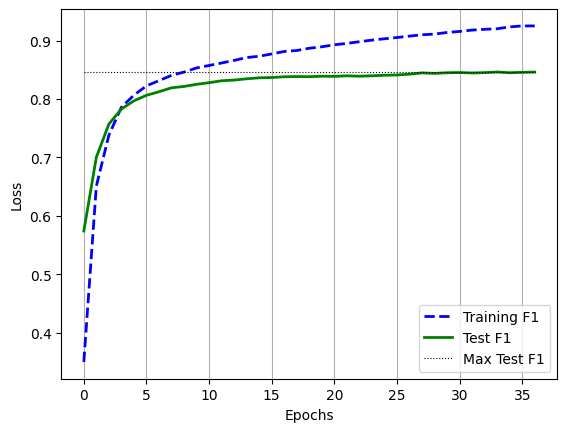

In [18]:
# plot f1
import matplotlib.pyplot as plt

plt.plot(
    range(len(history_char3_5)), [e[2] for e in history_char3_5], label='Training F1', linewidth=2.0, color='blue', ls='dashed'
)
plt.plot(
    range(len(history_char3_5)), [e[3] for e in history_char3_5], label='Test F1', linewidth=2.0, color='green', ls='solid'
)
plt.plot(
    range(len(history_char3_5)), [max([e[3] for e in history_char3_5])]*len(history_char3_5), label='Max Test F1', linewidth=0.8, color='black', ls='dotted'
)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(axis='x')

In [10]:
# word uni + char n gram(3, 5)

tokenizer_uni_char3_5 = CustomWordCharTokenizer()
tokenizer_uni_char3_5.fit(X_train)

Tokenizer fitted. Vocab size:  30002


In [11]:
train_samples_uni_char3_5 = create_samples(X_train, y_train_encoded, tokenizer_uni_char3_5)
test_samples_uni_char3_5 = create_samples(X_test, y_test_encoded, tokenizer_uni_char3_5)

model_uni_char3_5 = TicketTextClassifierV01(
    vocab_size=len(tokenizer_uni_char3_5),
    embedding_dim=EMBEDDING_DIM,
    pad_id=tokenizer_uni_char3_5.get_pad_id(),
    n_classes=N_CLASSES
).to(device)


criterion = nn.CrossEntropyLoss()

test_batches_uni_char3_5 = create_batch(TEST_BATCH_SIZE, test_samples_uni_char3_5, pad_id=tokenizer_uni_char3_5.get_pad_id(), 
                               device=device, shuffle=True, 
                               random_state=43)

In [12]:
history_uni_char3_5 = train_model(
    model_uni_char3_5, total_epochs=EPOCHS, train_samples=train_samples_uni_char3_5, test_batches=test_batches_uni_char3_5, training_batch_size=TRAIN_BATCH_SIZE,
    pad_id=tokenizer_uni_char3_5.get_pad_id(), criterion=criterion, early_stop=True, lr=0.0001, random_state=43,device=device
)

  2%|▏         | 1/50 [00:23<19:17, 23.61s/it]


        Epoch 1
        Train Loss: 1.4995 | Train F1: 0.3525
        Val   Loss: 1.0333 | Val   F1: 0.5633
        


  4%|▍         | 2/50 [00:48<19:39, 24.57s/it]


        Epoch 2
        Train Loss: 0.8346 | Train F1: 0.6536
        Val   Loss: 0.7225 | Val   F1: 0.7018
        


  6%|▌         | 3/50 [01:05<16:22, 20.90s/it]


        Epoch 3
        Train Loss: 0.6465 | Train F1: 0.7427
        Val   Loss: 0.6191 | Val   F1: 0.7620
        


  8%|▊         | 4/50 [01:23<15:08, 19.76s/it]


        Epoch 4
        Train Loss: 0.5616 | Train F1: 0.7896
        Val   Loss: 0.5674 | Val   F1: 0.7891
        


 10%|█         | 5/50 [01:39<13:48, 18.40s/it]


        Epoch 5
        Train Loss: 0.5137 | Train F1: 0.8140
        Val   Loss: 0.5368 | Val   F1: 0.8003
        


 12%|█▏        | 6/50 [01:55<12:58, 17.70s/it]


        Epoch 6
        Train Loss: 0.4783 | Train F1: 0.8302
        Val   Loss: 0.5158 | Val   F1: 0.8102
        


 14%|█▍        | 7/50 [02:12<12:23, 17.30s/it]


        Epoch 7
        Train Loss: 0.4507 | Train F1: 0.8411
        Val   Loss: 0.5000 | Val   F1: 0.8164
        


 16%|█▌        | 8/50 [02:28<11:59, 17.13s/it]


        Epoch 8
        Train Loss: 0.4291 | Train F1: 0.8496
        Val   Loss: 0.4879 | Val   F1: 0.8228
        


 18%|█▊        | 9/50 [02:45<11:32, 16.90s/it]


        Epoch 9
        Train Loss: 0.4116 | Train F1: 0.8570
        Val   Loss: 0.4783 | Val   F1: 0.8283
        


 20%|██        | 10/50 [03:02<11:16, 16.91s/it]


        Epoch 10
        Train Loss: 0.3937 | Train F1: 0.8639
        Val   Loss: 0.4710 | Val   F1: 0.8332
        


 22%|██▏       | 11/50 [03:18<10:50, 16.69s/it]


        Epoch 11
        Train Loss: 0.3793 | Train F1: 0.8704
        Val   Loss: 0.4645 | Val   F1: 0.8369
        


 24%|██▍       | 12/50 [03:34<10:28, 16.54s/it]


        Epoch 12
        Train Loss: 0.3648 | Train F1: 0.8750
        Val   Loss: 0.4594 | Val   F1: 0.8384
        


 26%|██▌       | 13/50 [03:51<10:13, 16.59s/it]


        Epoch 13
        Train Loss: 0.3535 | Train F1: 0.8786
        Val   Loss: 0.4553 | Val   F1: 0.8396
        


 28%|██▊       | 14/50 [04:07<09:54, 16.51s/it]


        Epoch 14
        Train Loss: 0.3428 | Train F1: 0.8842
        Val   Loss: 0.4513 | Val   F1: 0.8405
        


 30%|███       | 15/50 [04:23<09:32, 16.35s/it]


        Epoch 15
        Train Loss: 0.3316 | Train F1: 0.8867
        Val   Loss: 0.4482 | Val   F1: 0.8426
        


 32%|███▏      | 16/50 [04:40<09:23, 16.56s/it]


        Epoch 16
        Train Loss: 0.3220 | Train F1: 0.8914
        Val   Loss: 0.4461 | Val   F1: 0.8434
        


 34%|███▍      | 17/50 [04:57<09:07, 16.59s/it]


        Epoch 17
        Train Loss: 0.3130 | Train F1: 0.8953
        Val   Loss: 0.4442 | Val   F1: 0.8436
        


 36%|███▌      | 18/50 [05:14<08:51, 16.61s/it]


        Epoch 18
        Train Loss: 0.3034 | Train F1: 0.8977
        Val   Loss: 0.4424 | Val   F1: 0.8450
        


 38%|███▊      | 19/50 [05:30<08:34, 16.60s/it]


        Epoch 19
        Train Loss: 0.2953 | Train F1: 0.9016
        Val   Loss: 0.4411 | Val   F1: 0.8459
        


 40%|████      | 20/50 [05:47<08:20, 16.67s/it]


        Epoch 20
        Train Loss: 0.2877 | Train F1: 0.9034
        Val   Loss: 0.4400 | Val   F1: 0.8473
        


 42%|████▏     | 21/50 [06:03<08:01, 16.62s/it]


        Epoch 21
        Train Loss: 0.2801 | Train F1: 0.9056
        Val   Loss: 0.4392 | Val   F1: 0.8478
        


 44%|████▍     | 22/50 [06:20<07:44, 16.60s/it]


        Epoch 22
        Train Loss: 0.2725 | Train F1: 0.9088
        Val   Loss: 0.4386 | Val   F1: 0.8499
        


 46%|████▌     | 23/50 [06:37<07:27, 16.57s/it]


        Epoch 23
        Train Loss: 0.2648 | Train F1: 0.9123
        Val   Loss: 0.4395 | Val   F1: 0.8505
        


 48%|████▊     | 24/50 [06:53<07:09, 16.50s/it]


        Epoch 24
        Train Loss: 0.2606 | Train F1: 0.9143
        Val   Loss: 0.4382 | Val   F1: 0.8525
        


 50%|█████     | 25/50 [07:09<06:52, 16.52s/it]


        Epoch 25
        Train Loss: 0.2522 | Train F1: 0.9161
        Val   Loss: 0.4390 | Val   F1: 0.8521
        


 52%|█████▏    | 26/50 [07:26<06:39, 16.63s/it]


        Epoch 26
        Train Loss: 0.2460 | Train F1: 0.9195
        Val   Loss: 0.4396 | Val   F1: 0.8529
        


 54%|█████▍    | 27/50 [07:42<06:16, 16.37s/it]


        Epoch 27
        Train Loss: 0.2403 | Train F1: 0.9229
        Val   Loss: 0.4400 | Val   F1: 0.8538
        


 56%|█████▌    | 28/50 [07:59<06:01, 16.41s/it]


        Epoch 28
        Train Loss: 0.2355 | Train F1: 0.9231
        Val   Loss: 0.4414 | Val   F1: 0.8536
        


 58%|█████▊    | 29/50 [08:14<05:40, 16.24s/it]


        Epoch 29
        Train Loss: 0.2293 | Train F1: 0.9259
        Val   Loss: 0.4427 | Val   F1: 0.8540
        


 60%|██████    | 30/50 [08:31<05:24, 16.21s/it]


        Epoch 30
        Train Loss: 0.2248 | Train F1: 0.9265
        Val   Loss: 0.4430 | Val   F1: 0.8546
        


 62%|██████▏   | 31/50 [08:47<05:09, 16.31s/it]


        Epoch 31
        Train Loss: 0.2192 | Train F1: 0.9303
        Val   Loss: 0.4453 | Val   F1: 0.8543
        


 64%|██████▍   | 32/50 [09:03<04:54, 16.34s/it]


        Epoch 32
        Train Loss: 0.2135 | Train F1: 0.9320
        Val   Loss: 0.4460 | Val   F1: 0.8539
        


 64%|██████▍   | 32/50 [09:20<05:15, 17.50s/it]


        Epoch 33
        Train Loss: 0.2095 | Train F1: 0.9320
        Val   Loss: 0.4476 | Val   F1: 0.8539
        
Early stopping at epoch: 33


In [13]:
uni_char3_5_test_loss, uni_char3_5_test_pred, uni_char3_5_test_true = evaluate(
    model_uni_char3_5, test_batches_uni_char3_5, criterion
)
uni_char3_5_cm = cm_evaluate(uni_char3_5_test_true, uni_char3_5_test_pred)
format_cm(uni_char3_5_cm, class_names=list(labelencoder.classes_), normalize=True)

              precision    recall  f1-score   support

           0     0.8872    0.8884    0.8878      1425
           1     0.7970    0.7472    0.7713       352
           2     0.8687    0.8424    0.8553      2183
           3     0.8250    0.8704    0.8471      2724
           4     0.8846    0.8137    0.8477       424
           5     0.8129    0.8215    0.8172      1412
           6     0.9333    0.8803    0.9061       493
           7     0.9126    0.8847    0.8984       555

    accuracy                         0.8538      9568
   macro avg     0.8652    0.8436    0.8539      9568
weighted avg     0.8547    0.8538    0.8539      9568



,Pred: Access,Pred: Administrative rights,Pred: HR Support,Pred: Hardware,Pred: Internal Project,Pred: Miscellaneous,Pred: Purchase,Pred: Storage
True: Access,0.888421,0.002105,0.032982,0.051930,0.002807,0.017544,0.002105,0.002105
True: Administrative rights,0.019886,0.747159,0.014205,0.178977,0.000000,0.019886,0.017045,0.002841
True: HR Support,0.018781,0.002290,0.842419,0.077874,0.005955,0.046267,0.000458,0.005955
True: Hardware,0.026432,0.016153,0.037445,0.870411,0.003304,0.033774,0.005874,0.006608
True: Internal Project,0.009434,0.007075,0.066038,0.047170,0.813679,0.051887,0.000000,0.004717
True: Miscellaneous,0.020538,0.003541,0.048159,0.084986,0.011331,0.821530,0.003541,0.006374
True: Purchase,0.000000,0.008114,0.020284,0.064909,0.004057,0.020284,0.880325,0.002028
True: Storage,0.014414,0.005405,0.032432,0.043243,0.001802,0.018018,0.000000,0.884685


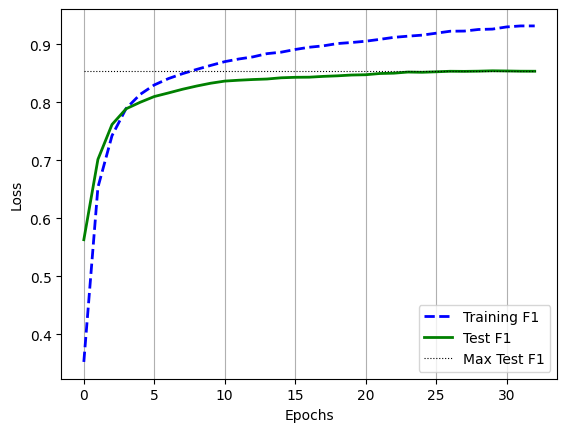

In [15]:
# plot f1
import matplotlib.pyplot as plt

plt.plot(
    range(len(history_uni_char3_5)), [e[2] for e in history_uni_char3_5], label='Training F1', linewidth=2.0, color='blue', ls='dashed'
)
plt.plot(
    range(len(history_uni_char3_5)), [e[3] for e in history_uni_char3_5], label='Test F1', linewidth=2.0, color='green', ls='solid'
)
plt.plot(
    range(len(history_uni_char3_5)), [max([e[3] for e in history_uni_char3_5])]*len(history_uni_char3_5), label='Max Test F1', linewidth=0.8, color='black', ls='dotted'
)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(axis='x')

In [16]:
#artifacts
import joblib
with open("../artifacts/custom_tokenizer_unicar3-5_v01.json",'w') as f:
    tokenizer_uni_char3_5.vocab_dump(f)
torch.save(model_uni_char3_5.state_dict(), "../artifacts/neural_model_unicar3-5_v01.pt")